![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 6 - Convolutional Neural Network</center>
### <center> 2D CNN</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/06_CNN/MainCnn2D.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
#-- Imports:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib
import torch

matplotlib.rc('font', **{'size' : 16})

For Colab users:

In [4]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/06_CNN/DeepLearningFramework ./DeepLearningFramework

In [5]:
#-- Record figures during training:
from DeepLearningFramework.Training import TrainClassficationModel

### Download CIFAR10 dataset:

In [7]:
import torchvision
import torchvision.transforms as transforms

oTrainSet = torchvision.datasets.CIFAR10(root='../../data', train=True,  download=True, transform=transforms.ToTensor())
oTestSet  = torchvision.datasets.CIFAR10(root='../../data', train=False, download=True, transform=transforms.ToTensor())
lClasses  = oTrainSet.classes
oTrainSet.data.shape

Files already downloaded and verified
Files already downloaded and verified


(50000, 32, 32, 3)

#### Plot some examples:

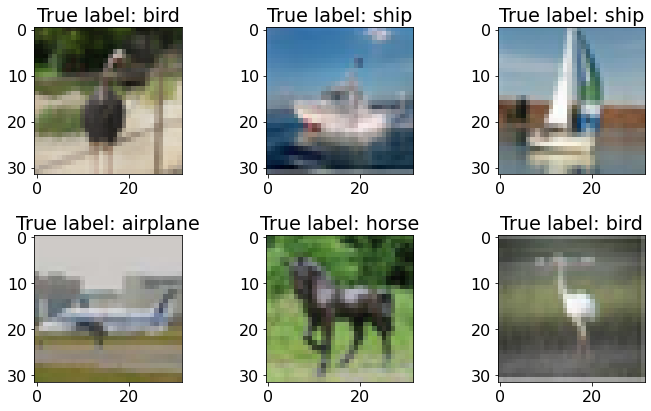

In [8]:
N, H, W, C = oTrainSet.data.shape
fig, _     = plt.subplots(2, 3, figsize=(10,6))
for ax in fig.axes:
    idx   = np.random.randint(N)
    mX, y = oTrainSet[idx]
    ax.imshow(np.transpose(mX.numpy(), (1,2,0)))
    ax.set_title(f'True label: {lClasses[y]}')
    
plt.tight_layout()
plt.show()

#### Compute mean and variance:

In [10]:
vMean = oTrainSet.data.mean(axis=(0,1,2)) / 255
vStd  = oTrainSet.data.std (axis=(0,1,2)) / 255
print('µ =', vMean)
print('σ =', vStd)

µ = [0.49139968 0.48215841 0.44653091]
σ = [0.24703223 0.24348513 0.26158784]


#### Set datasets with normalization:

In [11]:
oTransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(vMean, vStd)
])

oTrainSet.transform = oTransform
oTestSet .transform = oTransform

#### Create data loaders:

In [12]:
batchSize = 256
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   num_workers=2)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2)

#### Define the model (2D CNN):

In [14]:
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
import torchsummary
   
#-- Model:
def GetModel():
    oModel = nn.Sequential(
        nn.Identity(), #-- does nothing
        
        nn.Conv2d     (in_channels=3,   out_channels=30,  kernel_size=3, bias=False),
        nn.BatchNorm2d(num_features=30),
        nn.ReLU       (),
        nn.Dropout2d  (p=0.2),
        
        nn.Conv2d     (in_channels=30,  out_channels=60,  kernel_size=3, bias=False),
        nn.MaxPool2d  (kernel_size=2),
        nn.BatchNorm2d(num_features=60),
        nn.ReLU       (),
        nn.Dropout2d  (p=0.2),
                
        nn.Conv2d     (in_channels=60,  out_channels=120, kernel_size=3, bias=False),
        nn.BatchNorm2d(120),
        nn.ReLU(),
        nn.Dropout2d(p=0.2),
        
        nn.Conv2d     (in_channels=120, out_channels=240, kernel_size=3, bias=False),
        nn.BatchNorm2d(240),
        nn.ReLU       (),
        nn.Dropout2d  (p=0.2),
        
        nn.Conv2d     (in_channels=240, out_channels=500, kernel_size=3, bias=False),
        nn.MaxPool2d  (2),
        nn.BatchNorm2d(500),
        nn.ReLU       (),
        
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(500, 10),
    )
    
    return oModel

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
torchsummary.summary(GetModel(), (C, H, W), device='cpu');

Layer (type:depth-idx)                   Output Shape              Param #
├─Identity: 1-1                          [-1, 3, 32, 32]           --
├─Conv2d: 1-2                            [-1, 30, 30, 30]          810
├─BatchNorm2d: 1-3                       [-1, 30, 30, 30]          60
├─ReLU: 1-4                              [-1, 30, 30, 30]          --
├─Dropout2d: 1-5                         [-1, 30, 30, 30]          --
├─Conv2d: 1-6                            [-1, 60, 28, 28]          16,200
├─MaxPool2d: 1-7                         [-1, 60, 14, 14]          --
├─BatchNorm2d: 1-8                       [-1, 60, 14, 14]          120
├─ReLU: 1-9                              [-1, 60, 14, 14]          --
├─Dropout2d: 1-10                        [-1, 60, 14, 14]          --
├─Conv2d: 1-11                           [-1, 120, 12, 12]         64,800
├─BatchNorm2d: 1-12                      [-1, 120, 12, 12]         240
├─ReLU: 1-13                             [-1, 120, 12, 12]         --
├─Dr

#### Check whether GPU is available:

In [15]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
DEVICE

device(type='cuda', index=0)

#### Train the model:

In [18]:
oModel  = GetModel().to(DEVICE)
oOptim  = optim.AdamW(oModel.parameters(), lr=4e-3, betas=(0.9, 0.99), weight_decay=1e-2)
Loss    = nn.CrossEntropyLoss()
nEpochs = 30

TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim);

Epoch 000: | Train loss: 1.68004 | Val loss: 1.29022 | Train Accuracy: 0.3772 | Val Accuracy: 0.5414 | epoch time: 20.489 | <-- Checkpoint!
Epoch 001: | Train loss: 1.26828 | Val loss: 1.02116 | Train Accuracy: 0.5433 | Val Accuracy: 0.6353 | epoch time: 19.301 | <-- Checkpoint!
Epoch 002: | Train loss: 1.06258 | Val loss: 0.87933 | Train Accuracy: 0.6226 | Val Accuracy: 0.6899 | epoch time: 19.763 | <-- Checkpoint!
Epoch 003: | Train loss: 0.93292 | Val loss: 0.76316 | Train Accuracy: 0.6720 | Val Accuracy: 0.7349 | epoch time: 19.659 | <-- Checkpoint!
Epoch 004: | Train loss: 0.84559 | Val loss: 0.71973 | Train Accuracy: 0.7046 | Val Accuracy: 0.7556 | epoch time: 19.781 | <-- Checkpoint!
Epoch 005: | Train loss: 0.77929 | Val loss: 0.65104 | Train Accuracy: 0.7279 | Val Accuracy: 0.7778 | epoch time: 19.555 | <-- Checkpoint!
Epoch 006: | Train loss: 0.72410 | Val loss: 0.63925 | Train Accuracy: 0.7462 | Val Accuracy: 0.7827 | epoch time: 19.745 | <-- Checkpoint!
Epoch 007: | Train l

(array([1.68003621, 1.26827502, 1.06257917, 0.93291701, 0.84559141,
        0.77929284, 0.72409868, 0.67592069, 0.63091556, 0.60050602,
        0.56927848, 0.54268509, 0.51432291, 0.49557486, 0.46364131,
        0.44335162, 0.42134691, 0.40610089, 0.38553634, 0.3674159 ,
        0.35573267, 0.33782892, 0.31870853, 0.31091695, 0.29346242,
        0.28085715, 0.27172208, 0.26000182, 0.25397152, 0.24549255]),
 array([0.37718, 0.5433 , 0.62264, 0.67204, 0.70458, 0.7279 , 0.74618,
        0.76438, 0.78186, 0.79122, 0.8012 , 0.81258, 0.82064, 0.82884,
        0.83762, 0.84502, 0.85242, 0.86212, 0.86484, 0.87176, 0.87648,
        0.88196, 0.88844, 0.8907 , 0.89772, 0.90228, 0.90388, 0.90944,
        0.91122, 0.91468]),
 array([1.29021818, 1.02115569, 0.87933215, 0.76315662, 0.7197288 ,
        0.65104491, 0.63924699, 0.58061317, 0.55808482, 0.54042313,
        0.54874831, 0.50976596, 0.50916843, 0.50800252, 0.48743159,
        0.4921697 , 0.48887715, 0.47153253, 0.49370196, 0.48347353,
      

### Exercise
* Load the Fashion-MNIST dataset.
* Use 2D CNN, try to get the high accuracy (above 93% is good).

In [19]:
import torchvision
import torchvision.transforms as transforms

oTrainSet = torchvision.datasets.FashionMNIST(root='../../data', train=True,  download=True, transform=transforms.ToTensor())
oTestSet  = torchvision.datasets.FashionMNIST(root='../../data', train=False, download=True, transform=transforms.ToTensor())
oTrainSet.data.shape

torch.Size([60000, 28, 28])

In [20]:
lClasses  = oTrainSet.classes
lClasses

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

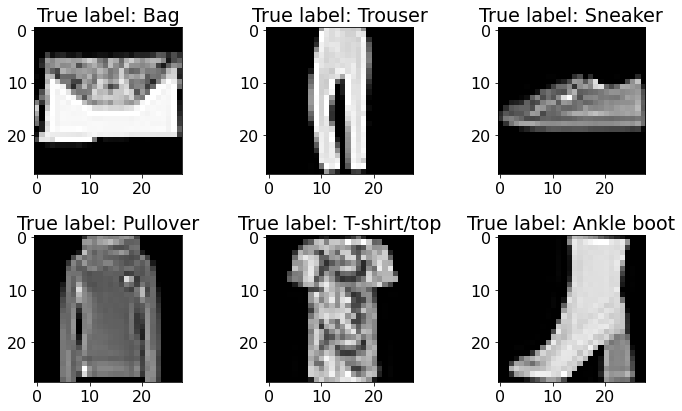

In [21]:
N, H, W = oTrainSet.data.shape
fig, _  = plt.subplots(2, 3, figsize=(10,6))
for ax in fig.axes:
    idx   = np.random.randint(N)
    mX, y = oTrainSet[idx]
    ax.imshow   (mX.squeeze(), cmap='gray')
    ax.set_title(f'True label: {lClasses[y]}')
    
plt.tight_layout()
plt.show()

In [25]:
???

Object `?` not found.


In [26]:
???

Object `??` not found.
